In [124]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,Input,Activation
from tensorflow.python.keras.models import Model,Sequential,InputLayer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import nltk
import tensorflow.python.keras.backend 
from nltk.corpus import conll2000
from tensorflow.python.keras.utils.all_utils import to_categorical
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss,crf_losses
from keras_contrib.metrics import crf_accuracy
from keras.optimizers import Adam
from itertools import chain
from gensim.models import Word2Vec
from collections import defaultdict
from nltk import ConfusionMatrix
import pickle    
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
'''
Hyper-parameter declarations
'''
BATCH_SIZE = 32
EPOCHS = 10
MAX_LEN = 75
EMBEDDING = 128
MAX_LEN = max(len(x) for x in conll2000.sents())
TAG_LIST = ['B','O','I']
TEST_TRAIN_DF_SPLIT_FACTOR = 8937 
# This is equal to 220663 lines of train as given in the assignment.
# We converted it into sentence format and again did the splitting for ease of processing

In [3]:
class Bi_lstm_metrics():
    
    def __init__(self, test_actual_tags, test_predicted_tags):
        '''
        The test_actual_tags contains actual tags for the above setences.
        The test_predicted_tags contains predicted tags for the test data.
        '''
        self.counter_dict = defaultdict(lambda: defaultdict(lambda:0))
        self.test_actual_tags = test_actual_tags
        self.test_predicted_tags = test_predicted_tags
        self.tag_metrics = defaultdict(lambda: defaultdict(lambda:0))
            
    def calc_tag_metrics(self):
        '''
        Calculate the per-POS accuracy for all the tags in the tag-set
        '''
        counter_dict = defaultdict(lambda: defaultdict(lambda:0))
        
        for i in range(len(self.test_actual_tags)):
            
            if(self.test_actual_tags[i] == self.test_predicted_tags[i]):
                counter_dict[self.test_actual_tags[i]]['TP'] += 1
            else:
                counter_dict[self.test_actual_tags[i]]['FN']    += 1
                counter_dict[self.test_predicted_tags[i]]['FP'] += 1
        
        
        for tag in counter_dict.keys():
            try:
                self.tag_metrics[tag]['Precision'] = counter_dict[tag]['TP']/(counter_dict[tag]['TP']+counter_dict[tag]['FP'])
                self.tag_metrics[tag]['Recall'] = counter_dict[tag]['TP']/(counter_dict[tag]['TP']+counter_dict[tag]['FN'])
                self.tag_metrics[tag]['F1_score'] = 2*(self.tag_metrics[tag]['Precision']*self.tag_metrics[tag]['Recall'])/(self.tag_metrics[tag]['Precision']+self.tag_metrics[tag]['Recall'])

            except ZeroDivisionError:
                continue               
        self.counter_dict =  counter_dict
        
    def generate_confusion_matrix(self):
        '''
        Generate confusion matrix for the particular fold
        '''
        CM = ConfusionMatrix(self.test_actual_tags ,self.test_predicted_tags)
        print(CM)
        
    def accuracy(self):
        '''
        Calculate average accuracy score
        '''
        TP =0
        FP =0
        for tag in self.counter_dict.keys():
            if (tag !='PAD' and tag !='O'):
                TP += self.counter_dict[tag]['TP']
                FP += self.counter_dict[tag]['FP']
        
        return TP/(TP+FP)
        
        
    def print_sample(self):
        '''
        Prints a sample of n = 5 actual and predicted tagged sentences for reference
        '''
        for i in range(5):
            print("Actual :",self.test_actual_tags[i])
            print("Predicted :",self.test_predicted_tags[i])
        
    def get_tag_metrics(self):
        '''
        Prints the per POS precision,recall and F1 score of predicted tags
        '''
        
        print ("{:<10} {:<10} {:<10} {:<10}".format('TAG', 'PRECISION', 'RECALL','F1_SCORE'))
        
        for key in self.tag_metrics.keys():
            precision = str(round(self.tag_metrics[key]['Precision'], 2))
            recall    = str(round(self.tag_metrics[key]['Recall'], 2))
            F1_score  = str(round(self.tag_metrics[key]['F1_score'], 2))
            print ("{:<10} {:<10} {:<10} {:<10} ".format(key, precision,recall,F1_score))

In [4]:
'''
Reading data into data frame
'''
df_train = pd.read_csv('train.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])
df_test = pd.read_csv('test.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])

In [5]:
'''
Initial pre-processing
'''
df_train['Chunk_tag'] = df_train['Chunk_tag'].str.split("-", n = 1, expand = True) 
df_test['Chunk_tag']  = df_test['Chunk_tag'].str.split("-", n = 1, expand = True) 

In [6]:
'''
Dividing the test and train dataframes to a list of dataframes for each sentence 
'''
idx = [-1]+ df_train.index[df_train.isnull().all(1)].tolist() + [df_train.shape[0]]
list_of_train_dfs = [df_train.iloc[idx[n]+1:idx[n+1]] for n in range(len(idx)-1)]

idx = [-1]+ df_test.index[df_test.isnull().all(1)].tolist() + [df_test.shape[0]]
list_of_test_dfs = [df_test.iloc[idx[n]+1:idx[n+1]] for n in range(len(idx)-1)]

In [7]:
'''
Creating a list of dataframes to be fed for training.
Each dataframe contains one sentence split into words row-wise.
'''
df_full_data = df_train.append(df_test, ignore_index=True)
list_of_dfs = []
list_of_dfs.extend(list_of_train_dfs)
list_of_dfs.extend(list_of_test_dfs)

In [8]:
'''
Calculating number of words in the dataset
'''
n_words = len(set(df_full_data["POS_tag"].values))
print("Number of words in the dataset: ", n_words)

Number of words in the dataset:  45


In [9]:
'''
Creating proper encodings for words/tags.
Initially some testing was done taking words features only, then we switched to POS tags
So word2idx essentially represents POSTags2idx mappings.
tag2idx refers to mapping of 'B','I','O' and 'PAD' tags
'''
word2idx = {w: i + 2 for i, w in enumerate(set(df_full_data['POS_tag']))} #Encoded POS tag
word2idx["UNK"] = 1 # Unknown tags
word2idx["PAD"] = 0 # Paddings
idx2word = {i: w for w, i in word2idx.items()} # index to POS tag mapping
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(TAG_LIST)}
tag2idx["PAD"] = 0 
idx2tag = {i: w for w, i in tag2idx.items()}


In [11]:
'''
Apply embeddings and padding to data
'''
# Convert each sentence from list of Token to list of pos_index
X = [[word2idx[w] for w in df['POS_tag']] for df in list_of_dfs]
# Padding each tagged sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])# Convert Tag/Label to tag_index
y = [[tag2idx[t] for t in df['Chunk_tag']] for df in list_of_dfs]
# Padding each tag sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
# One-Hot encode
y = [to_categorical(i, num_classes=(len(TAG_LIST)+1)) for i in y]  

In [15]:
'''
Building bi-LSTM CRF model
'''
# Model definition

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LEN,)))  
model.add(Embedding(input_dim=n_words+2, output_dim=EMBEDDING,input_length=MAX_LEN, mask_zero=True) )
model.add(Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.1))) 
model.add(Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))) 
#### BiLSTM with return sequence true
model.add(TimeDistributed(Dense(100, activation="relu")))  #### Output Layer
# model.add(CRF(len(TAG_LIST)+1))
#model.add(CRF(4))
model.add(TimeDistributed(Dense(4, activation="softmax"))) 
#model.compile(optimizer="rmsprop", loss=crf_loss, metrics=crf_accuracy)

model.compile(loss= "categorical_crossentropy" ,optimizer=Adam(0.001),metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 78, 128)           6016      
_________________________________________________________________
bidirectional (Bidirectional (None, 78, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 78, 200)           285600    
_________________________________________________________________
time_distributed (TimeDistri (None, 78, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 78, 4)             404       
Total params: 575,288
Trainable params: 575,288
Non-trainable params: 0
_________________________________________________________________


In [16]:
'''
Splitting Train and test into data and chunk tags

'''

X_train = X[:TEST_TRAIN_DF_SPLIT_FACTOR]  
X_test  = X[TEST_TRAIN_DF_SPLIT_FACTOR:]

Y_train = y[:TEST_TRAIN_DF_SPLIT_FACTOR]
Y_test  = y[TEST_TRAIN_DF_SPLIT_FACTOR:]

In [19]:
'''
Training the model
'''
history = model.fit(X_train, np.array(Y_train), batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.3, verbose=2)

Epoch 1/10
196/196 - 80s - loss: 0.1546 - accuracy: 0.7797 - val_loss: 0.0686 - val_accuracy: 0.9246
Epoch 2/10
196/196 - 81s - loss: 0.0593 - accuracy: 0.9336 - val_loss: 0.0561 - val_accuracy: 0.9415
Epoch 3/10
196/196 - 79s - loss: 0.0497 - accuracy: 0.9478 - val_loss: 0.0505 - val_accuracy: 0.9493
Epoch 4/10
196/196 - 80s - loss: 0.0457 - accuracy: 0.9527 - val_loss: 0.0474 - val_accuracy: 0.9515
Epoch 5/10
196/196 - 86s - loss: 0.0429 - accuracy: 0.9555 - val_loss: 0.0455 - val_accuracy: 0.9533
Epoch 6/10
196/196 - 82s - loss: 0.0408 - accuracy: 0.9575 - val_loss: 0.0437 - val_accuracy: 0.9564
Epoch 7/10
196/196 - 88s - loss: 0.0394 - accuracy: 0.9585 - val_loss: 0.0425 - val_accuracy: 0.9564
Epoch 8/10
196/196 - 82s - loss: 0.0373 - accuracy: 0.9607 - val_loss: 0.0419 - val_accuracy: 0.9576
Epoch 9/10
196/196 - 82s - loss: 0.0362 - accuracy: 0.9611 - val_loss: 0.0424 - val_accuracy: 0.9569
Epoch 10/10
196/196 - 87s - loss: 0.0343 - accuracy: 0.9630 - val_loss: 0.0398 - val_accura

In [88]:
'''
Predicting the test data 
'''
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(Y_test, -1)

In [89]:
'''
Inverse mapping to get actual and predicted tags
'''
pred_tag = [[idx2tag[i] for i in row] for row in pred]
actual_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

In [90]:

'''
Calculating Tag metrics
'''
metrics = Bi_lstm_metrics(list(chain.from_iterable(actual_tag)),list(chain.from_iterable(pred_tag)))
metrics.calc_tag_metrics()
metrics.get_tag_metrics()
metrics.generate_confusion_matrix()
metrics.accuracy()*100



TAG        PRECISION  RECALL     F1_SCORE  
B          0.97       0.97       0.97       
I          0.94       0.96       0.95       
O          0.05       0.94       0.1        
    |                           P |
    |                           A |
    |      B      I      O      D |
----+-----------------------------+
  B | <23024>   780     48      . |
  I |    570 <16669>   106      . |
  O |    132    219  <5829>     . |
PAD |      .      . 109637     <.>|
----+-----------------------------+
(row = reference; col = test)



95.89070879837658

AxesSubplot(0.125,0.125;0.62x0.755)


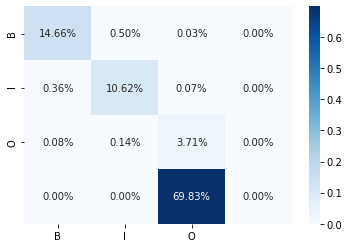

In [122]:
'''
Heap map outpiut
'''
pred_tag_trimmed =[]
for i in range(len(pred_tag)):
    k= pred_tag[i][:-1]
    pred_tag_trimmed.append(k)

cf_matrix = confusion_matrix(list(chain.from_iterable(actual_tag)) ,list(chain.from_iterable(pred_tag)))
print(sns.heatmap(cf_matrix/np.sum(cf_matrix),xticklabels=['B', 'I','O'], yticklabels=['B','I','O'], annot=True,fmt='.2%', cmap='Blues'))
#print(sns.heatmap(cf_matrix, annot=True,xticklabels=['B', 'I','O'], yticklabels=['B','I','O'],fmt="d", cmap='Blues'))

In [36]:
'''
Dumping data for error analysis
'''
pred_tag_dump =[]
for pred in pred_tag:
    l = pred.insert(0,'O')
    pred_tag_dump.append(pred)
with open('Bi_LSTM_test_Y_pred.pkl', 'wb') as f:
    pickle.dump(pred_tag_dump, f) 